In [37]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [38]:
df = pd.read_csv("archive/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [39]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

In [40]:
print(df.isna().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [41]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(subset=["TotalCharges"], inplace=True)

In [42]:
df_features = df.drop(columns=["customerID", "Churn"]) 

In [43]:
numeric_features = df_features.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = df_features.select_dtypes(include=["object"]).columns.tolist()

In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

X = preprocessor.fit_transform(df_features)

In [45]:
inertias = []
sil_scores = []
ks = range(2, 11)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

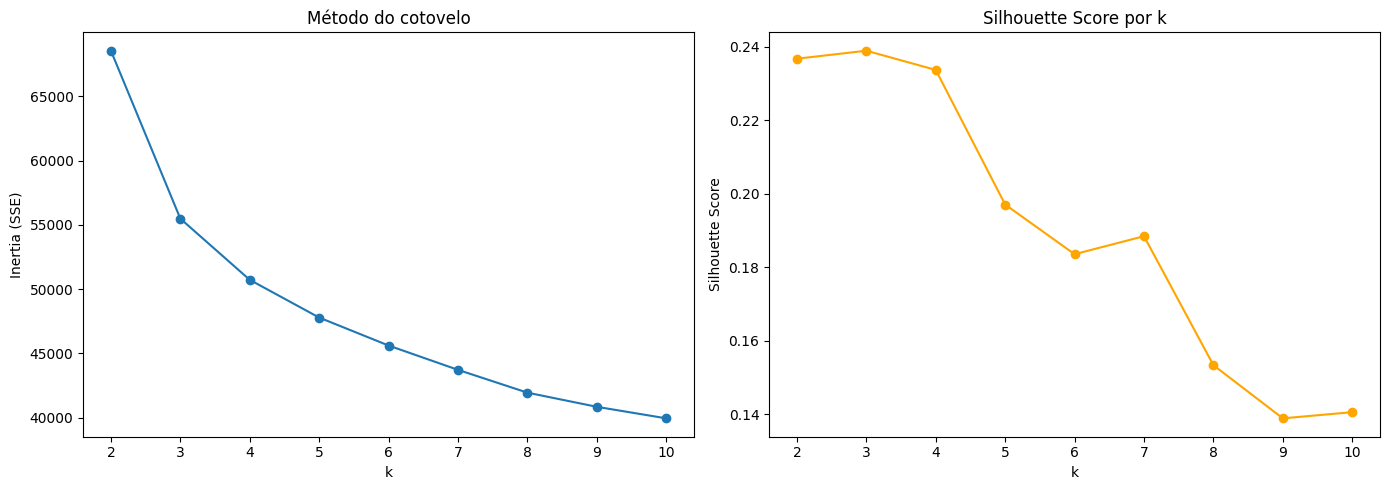

In [46]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
axes[0].plot(list(ks), inertias, marker='o')
axes[0].set_title('Método do cotovelo')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia (SSE)')

axes[1].plot(list(ks), sil_scores, marker='o', color='orange')
axes[1].set_title('Silhouette Score por k')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [47]:
best_k_sil = int(ks[np.argmax(sil_scores)])
print(f"Silhouette: k = {best_k_sil} (silhouette = {max(sil_scores):.4f})")

Silhouette: k = 3 (silhouette = 0.2389)


In [48]:
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("pca", PCA(n_components=0.5, random_state=42)),
    ("kmeans", KMeans(n_clusters=3, random_state=42))
])

pipeline.fit(df_features)

,steps,"[('preprocess', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [49]:
X_pca = pipeline.named_steps["pca"].transform(
    pipeline.named_steps["preprocess"].transform(df_features)
)

labels = pipeline.named_steps["kmeans"].predict(X_pca)

In [50]:
sil = silhouette_score(X_pca, labels)
db = davies_bouldin_score(X_pca, labels)

print(f"Silhouette Score: {sil:.4f}")
print(f"Davies-Bouldin Score: {db:.4f}")


Silhouette Score: 0.4911
Davies-Bouldin Score: 0.7986


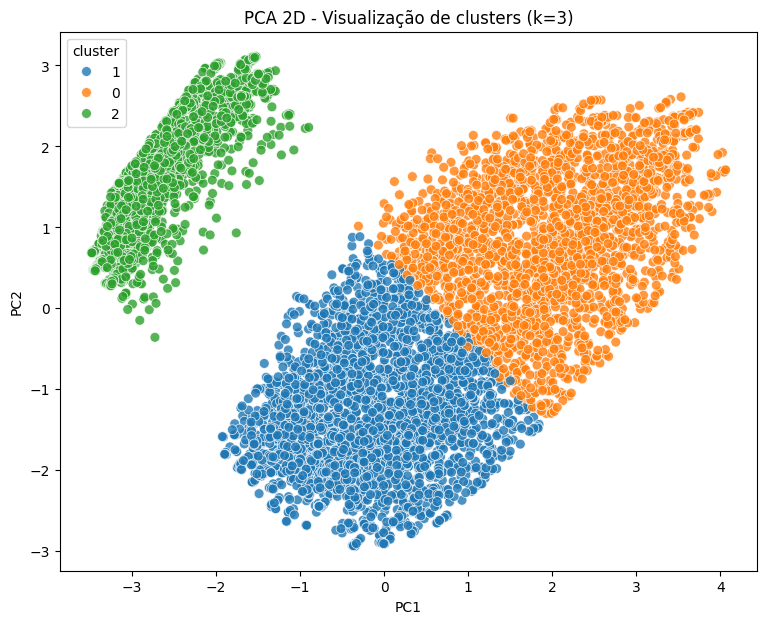

In [51]:
# ---- Visualization ----
plt.figure(figsize=(9,7))
palette = sns.color_palette("tab10", n_colors=labels.max()+1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels.astype(str), palette=palette, s=50, alpha=0.8)
plt.title(f"PCA 2D - Visualização de clusters (k={labels.max()+1})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='cluster')
plt.show()


In [52]:

joblib.dump(pipeline, "telco_kmeans_pipeline.pkl")

['telco_kmeans_pipeline.pkl']

In [53]:
df['cluster'] = labels
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,cluster
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,1
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,0
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,0
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,1
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,1


cluster  Churn
0        No       84.914530
         Yes      15.085470
1        No       55.769231
         Yes      44.230769
2        No       92.565789
         Yes       7.434211
Name: proportion, dtype: float64


<Axes: xlabel='cluster', ylabel='count'>

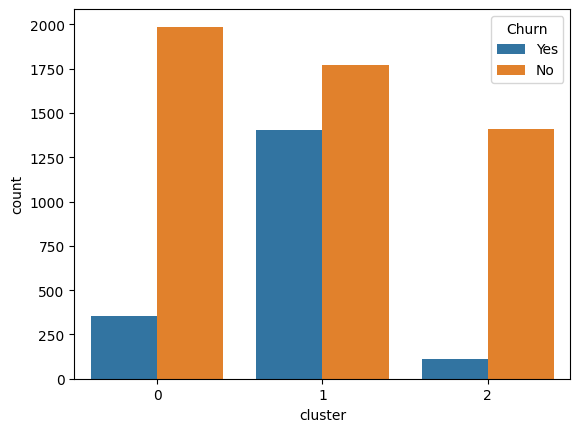

In [54]:
cluster_churn = df.groupby('cluster')['Churn'].value_counts(normalize=True) * 100
print(cluster_churn)

import seaborn as sns
sns.countplot(data=df, x='cluster', hue='Churn')
